In [2]:
# Import
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad


In [3]:
# Parameters
n = 30
C = 4
meanT = 40
meanM = 15
oneItemST = 3

# The number of items in a customer's cart is an EXPONENTIAL random variable
def expCDF(x_, lambda_):
    return 1 - math.exp(- lambda_ * x_)

def expPDF(x_, lambda_):
    return lambda_ * math.exp(- lambda_ * x_)

# Factors
p = 0.5
K = 8

# CSV name
csv_name = "VTM_Exponential_New"

In [4]:

CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)

CSV = pd.concat([CSV[CSV["type"] == "scalar"], CSV[CSV["type"] == "vector"]])

# CSV.to_csv(f"{csv_name}_cleaned.csv", index=False)

In [5]:

CSV_Vector = CSV[CSV["type"] == "vector"]

# W: Mean Waiting Time [Queues]
Exp_W = CSV_Vector[CSV_Vector["module"].str.contains("SuperMarket.checkout.queues")]
Exp_W = Exp_W[Exp_W["name"] == "queueingTime:vector"]

# NQ: Mean Number of Customers in Queue [Queues]
Exp_NQ_Vector = CSV_Vector[CSV_Vector["module"].str.contains("SuperMarket.checkout.queues")]
Exp_NQ_Vector = Exp_NQ_Vector[Exp_NQ_Vector["name"] == "queueLength:vector"]

CSV_Scalar = CSV[CSV["type"] == "scalar"]

# NQ: Mean Number of Customers in Queue [Queues]
Exp_NQ = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.queues")]
Exp_NQ = Exp_NQ[Exp_NQ["name"] == "queueLength:timeavg"]

# RHO: Mean Utilization [Queues]
Exp_RHO = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.queues")]
Exp_RHO = Exp_RHO[Exp_RHO["name"] == "busy:timeavg"]

# S: Mean Service Time (t_S) [LocalSink] 
Exp_S = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.localSink")]
Exp_S = Exp_S[Exp_S["name"] == "totalServiceTime:mean"]

# Dictionary for containing all the DataFrames
CSV_Dict = {
    "W": Exp_W,
    "NQ_Vector": Exp_NQ_Vector,
    "NQ": Exp_NQ,
    "RHO": Exp_RHO,
    "S": Exp_S
}

# PI: Performance Indexes
PI = {}

# Configurations
config = {}

for _, row in Exp_W.iterrows():
    # The key of config is the run number and the value is the value of T
    config[row["run"].split("-")[2]] = "BASE"


for key in CSV_Dict:
    
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key] = {}

    for c in config:
        # config[c] is a value of T
        PI[key][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV_Dict[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific value of T

        # In row we save the run number
        run = row["run"].split("-")[2]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"
            if key == "W" or key == "NQ_Vector":
                PI[key][config[run]][run][string] = row["vecvalue"]

            else:
                # For the current run we save the PI value of the queue "string" (e.g. Q0)
                PI[key][config[run]][run][string] = float(row["value"]) 

        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            if key == "TW":
                PI[key][config[run]][run] = row["vecvalue"]
            else:
                # For the current run we save the PI value of the overall system
                PI[key][config[run]][run] = float(row["value"])


# PI_df: Performance Indexes DataFrame
PI_df = {}

# In Q we are going to save the names of the queues in the format Q0, Q1, ...
Q = []
for i in range(C):
    Q.append(f"Q{i}")


# --- Initialization Phase ---

for pi in PI:

    # The key of PI_df is the Performance Index and the value is a dictionary
    PI_df[pi] = {}

    for config in PI[pi]:

        if pi != "TW":
            # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
            PI_df[pi][config] = pd.DataFrame(columns=Q)

        else:
            # If pi is TW we create a DataFrame with just one column GS (Global Sink)
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

# --- End of Initialization Phase ---


for pi in PI:

    for config in PI[pi]:
    
        for run in PI[pi][config]:
            
            # Here we need to check if PI[pi][config][run] is different from {}
            # because if it is {} it means that the run was not related to 
            # that specific value of T
            if PI[pi][config][run]:

                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    # If it is a dictionary it means that
                    # it contains the PI values for each queue
                    for q in PI[pi][config][run]:
                        # We add the PI value of the queue q to the DataFrame
                        # at the row 'run' and at the column 'q'
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    # If it is not a dictionary it means that
                    # it contains the PI value for the overall system

                    # We add the PI value of the overall system to the DataFrame
                    # at the row 'run'
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        # We sort the DataFrame by the index (run number)
        PI_df[pi][config] = PI_df[pi][config].sort_index()
        # We reset the index of the DataFrame to start from 0
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)



In [8]:
#PI_df["NQ_Vector"]["BASE"]

,Q0,Q1,Q2,Q3
0,0 1 0 1 2 1 0 1 0 1 0 1 0 1 2 3 2 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 2 1 2 1 2 1 0 1 2 ...,0 1 0 1 0 1 0 1 2 1 0 1 0 1 0 1 2 1 2 1 0 1 2 ...
1,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 2 1 0 ...,0 1 2 3 2 1 2 3 2 3 4 3 4 3 2 3 2 3 2 1 2 1 2 ...,0 1 0 1 2 3 2 3 2 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...
2,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 2 1 2 1 0 1 0 1 0 1 0 1 2 1 0 1 0 1 0 ...,0 1 2 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...
3,0 1 0 1 2 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 2 1 0 1 0 1 0 ...,0 1 2 3 2 1 0 1 0 1 0 1 0 1 0 1 2 1 2 3 2 3 2 ...,0 1 0 1 0 1 0 1 2 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...
4,0 1 0 1 2 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 2 1 2 3 2 3 4 5 4 3 4 3 2 1 0 1 0 1 2 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 2 1 0 ...
5,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 2 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 2 ...,0 1 0 1 0 1 0 1 2 1 0 1 2 3 2 1 0 1 0 1 0 1 0 ...
6,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 2 1 0 1 0 1 2 3 2 1 0 ...,0 1 0 1 0 1 2 3 2 3 2 3 2 3 2 1 2 1 0 1 2 1 0 ...
7,0 1 0 1 2 1 0 1 2 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 2 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 2 1 0 1 2 ...,0 1 0 1 0 1 0 1 0 1 2 3 2 3 4 3 2 3 2 1 0 1 0 ...
8,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 2 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 2 ...,0 1 0 1 0 1 2 1 0 1 0 1 0 1 0 1 0 1 0 1 2 1 2 ...
9,0 1 0 1 0 1 0 1 0 1 0 1 2 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 0 1 2 3 2 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ...,0 1 0 1 2 1 2 3 4 3 2 3 2 3 2 3 2 1 2 3 2 3 2 ...


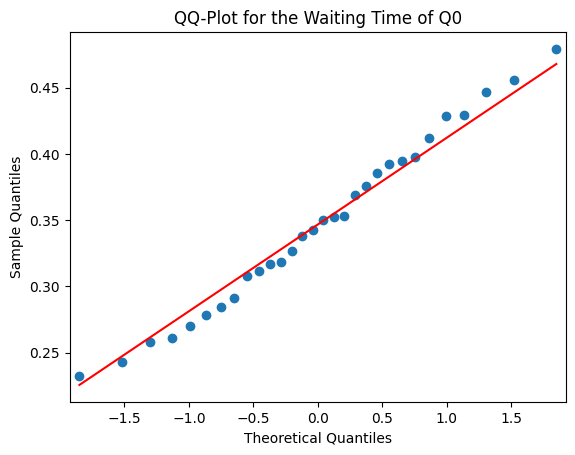

In [24]:
# from statsmodels.graphics.gofplots import qqplot
# import numpy as np
# # Plot QQ-Plot for the Waiting Time of Q0
# import matplotlib.pyplot as plt

# qqplot(PI_df["NQ"]["BASE"]["Q3"], line='s')
# plt.title('QQ-Plot for the Waiting Time of Q0')
# plt.show()

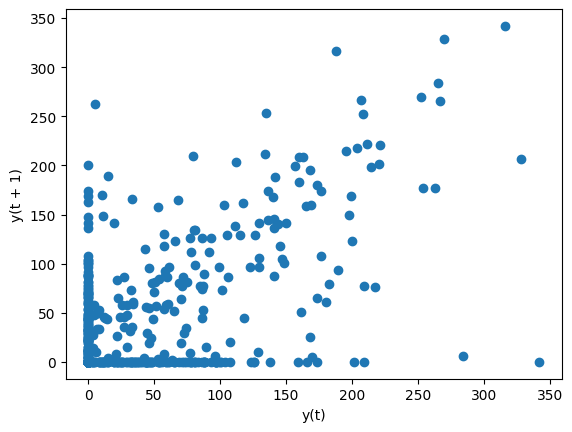

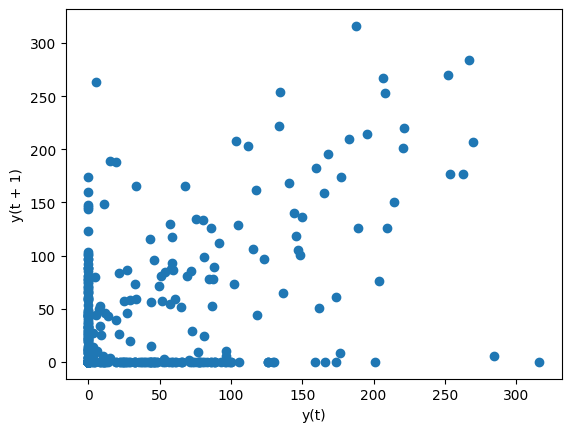

C:\Users\giova\AppData\Local\Temp\ipykernel_14980\2542735261.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(values, hist=False, rug=True)


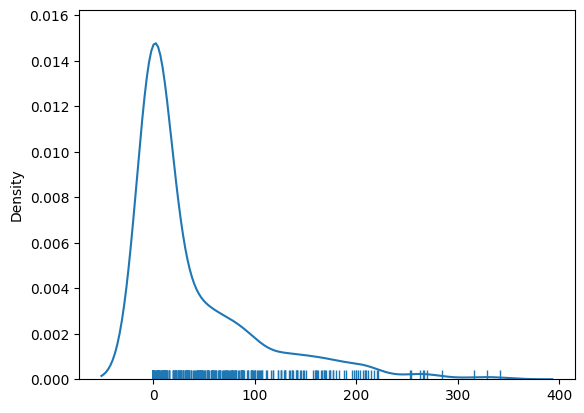

In [36]:
# from statsmodels.graphics.gofplots import qqplot
# from pandas.plotting import lag_plot

# values = PI_df["W"]["BASE"]["Q3"].iloc[13]
# values = values.split(" ")
# values = [float(i) for i in values]
# values = pd.DataFrame(values)
# lag_plot(values)
# plt.show()
# subsample = values.sample(frac=0.7)
# subsample.sort_index(inplace=True)
# lag_plot(subsample)
# plt.show()
# sns.distplot(values, hist=False, rug=True)
# plt.show()

In [38]:
# Subsampling and Mean Computation
for index, row in PI_df["W"]["BASE"].iterrows():
    for q in Q:
        values = row[q].split(" ")
        values = [float(v) for v in values]
        values = pd.DataFrame(values)
        subsample = values.sample(frac=0.7)
        PI_df["W"]["BASE"].loc[index, q] = subsample.mean()[0]

In [50]:
PI_df["W"]["BASE"]

,Q0,Q1,Q2,Q3
0,0.654095,0.470546,45.775482,44.178998
1,0.571933,0.700612,45.92537,48.058053
2,0.493332,0.642605,38.313723,43.605982
3,0.724915,0.876633,44.878382,43.407812
4,0.298785,0.30956,44.837921,42.706626
5,0.764359,0.585966,36.274634,43.635743
6,0.599976,0.677899,38.409694,45.008402
7,0.782801,0.38272,46.968554,50.403962
8,0.308376,0.763081,32.035809,45.43597
9,0.557793,0.548408,37.494042,53.701827


In [48]:
pi = "W"
P_LOG = {}
P_LOG[pi] = {}

P_LOG[pi]["BASE"] = pd.DataFrame(columns=Q)
for q in Q:
    P_LOG[pi]["BASE"][q] = np.log(PI_df[pi]["BASE"][q].values.astype(np.float64).tolist())


In [49]:
P_LOG["W"]["BASE"]

,Q0,Q1,Q2,Q3
0,-0.424502,-0.753862,3.823749,3.788250
1,-0.558734,-0.355800,3.827018,3.872410
2,-0.706573,-0.442225,3.645808,3.775194
3,-0.321701,-0.131667,3.803956,3.770639
4,-1.208031,-1.172602,3.803054,3.754354
5,-0.268717,-0.534493,3.591119,3.775877
6,-0.510866,-0.388757,3.648310,3.806849
7,-0.244876,-0.960451,3.849478,3.920070
8,-1.176435,-0.270391,3.466854,3.816304
9,-0.583768,-0.600735,3.624182,3.983447


In [51]:
PI_TABLE = {}


for key in PI_df:
    if key == "NQ_Vector":
        continue
    PI_TABLE[key] = pd.DataFrame(columns=["Theoretical", "Mean", "CI - LB", "CI - UB"])
    
    # Mean Value of the "n" repetitions for each Queue
    PI_TABLE[key]["Mean"] = PI_df[key]["BASE"].mean()

    if key == "W":
        # CI 95% (Cox Method)
        # Lower Bound
        PI_TABLE[key]["CI - LB"] = np.exp(P_LOG[key]["BASE"].mean() + (P_LOG[key]["BASE"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[key]["BASE"].std()**2 / n) + (P_LOG[key]["BASE"].std()**4 / (2 * (n-1))))))
        # Upper Bound
        PI_TABLE[key]["CI - UB"] = np.exp(P_LOG[key]["BASE"].mean() + (P_LOG[key]["BASE"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[key]["BASE"].std()**2 / n) + (P_LOG[key]["BASE"].std()**4 / (2 * (n-1))))))

    else:
        # CI 95% (Normal)
        # Lower Bound
        PI_TABLE[key]["CI - LB"] = PI_df[key]["BASE"].mean() - (1.96 * (PI_df[key]["BASE"].std() / math.sqrt(n)))
        # Upper Bound
        PI_TABLE[key]["CI - UB"] = PI_df[key]["BASE"].mean() + (1.96 * (PI_df[key]["BASE"].std() / math.sqrt(n)))



In [52]:
for key in PI_TABLE:
    print(f"[{key}]:")
    print(PI_TABLE[key])
    print("\n")

[W]:
   Theoretical       Mean    CI - LB    CI - UB
Q0         NaN   0.593371   0.538174   0.658087
Q1         NaN   0.641725   0.587174   0.705769
Q2         NaN  44.582823  41.946378  47.430331
Q3         NaN  47.040153  44.243622  50.086134


[NQ]:
   Theoretical      Mean   CI - LB   CI - UB
Q0         NaN  0.002995  0.002761   0.00323
Q1         NaN  0.003402  0.003119  0.003684
Q2         NaN  0.325612   0.30483  0.346395
Q3         NaN  0.346722  0.322885   0.37056


[RHO]:
   Theoretical      Mean   CI - LB   CI - UB
Q0         NaN  0.068394  0.067328  0.069459
Q1         NaN  0.068459  0.066834  0.070084
Q2         NaN  0.492145  0.485497  0.498793
Q3         NaN  0.496031  0.486992  0.505071


[S]:
   Theoretical       Mean    CI - LB    CI - UB
Q0         NaN  13.226692  13.111825  13.341558
Q1         NaN  13.106028  13.003293  13.208762
Q2         NaN  67.018288  66.366837  67.669739
Q3         NaN  67.810909  67.239446  68.382372




In [53]:
# Theoretical Formulas and Computations

# g(M) = round(M) + 1 = floor(M+1.5)
def g(x):
    return math.floor(x+1.5)  

def integrand(x):
    return (g(x) * expPDF(x, (1/(meanM-1))))

def integrand_2(x):
    return ((g(x)**2) * expPDF(x, (1/(meanM-1))))


# Number of Quick Tills
quickTills = int(p*C)

# Interarrival Rate
lambdaT = 1/meanT

temp = {}

if (quickTills == 0) or quickTills == C:
    # There are no Quick Tills or all the Tills are Quick Tills
    # So the probability alphaK of being routed to a Quick Till is either 0 or 1

    pi_ = 1/C
    lambdaT_ = lambdaT*pi_

    meanST_ = meanM * oneItemST
    lambdaST_ = 1/meanST_
    
    # Utilization
    rho_ = lambdaT_/lambdaST_

    # Mean Number of Customers in M/M/1
    N_ = rho_/(1-rho_)

    # Mean Number of Customers in a Queue
    NQ_ = N_ - rho_

    # Mean Response Time
    R_ = N_/lambdaT_

    # Mean Waiting Time
    W_ = R_ - meanST_


    temp["NQ"] = NQ_
    temp["RHO"] = rho_
    temp["S"] = meanST_
    temp["W"] = W_


    for key in PI_TABLE:
        PI_TABLE[key]["Theoretical"] = [temp[key]] * C

else:
    # There are Quick Tills AND Normal Tills
    # So the probability alphaK of being routed to a Quick Till is 0 < alphaK < 1
    
    # CDF of an EXPONENTIAL distribution
    alphaK = expCDF((K-0.5), (1/(meanM-1)))

    # --- Quick Tills ---

    # Probability of being routed to a specific Quick Till (i)
    # Inside a subsystem (Quick Tills or Normal Tills) the
    # probability of being routed to a specific Till is the
    # same (i.e. "equallylikely")
    pi_i = alphaK/quickTills
    
    # Interarrival Rate for an individual Quick Till
    lambdaT_i = lambdaT*pi_i
    
    # Mean Number of items in a customer's cart for an individual Quick Till
    meanM_i = (quad(integrand, 0, (K-0.5), limit=200)[0])/alphaK

    # Mean Service Time for an individual Quick Till
    meanST_i = meanM_i * oneItemST


    # Variance = E[X^2] - E[X]^2
    # Variance of M_i
    VarM_i = ((quad(integrand_2, 0, (K-0.5), limit=200)[0])/alphaK) - meanM_i**2

    # Variance of ST_i
    VarST_i = VarM_i * oneItemST**2
    
    
    # Performance Indeces for an individual Quick Till

    rho_i = lambdaT_i * meanST_i
    N_i = rho_i + ((rho_i**2 + lambdaT_i**2 * VarST_i)/(2*(1-rho_i)))
    NQ_i = N_i - rho_i
    R_i = N_i/lambdaT_i
    W_i = R_i - meanST_i
    
    temp["NQ"] = {}
    temp["NQ"]["i"] = NQ_i

    temp["RHO"] = {}
    temp["RHO"]["i"] = rho_i

    temp["S"] = {}
    temp["S"]["i"] = meanST_i

    temp["W"] = {}
    temp["W"]["i"] = W_i


    # --- Normal Tills ---

    # Probability of being routed to a specific Normal Till (j)
    # Inside a subsystem (Quick Tills or Normal Tills) the
    # probability of being routed to a specific Till is the
    # same (i.e. "equallylikely")
    pi_j = (1-alphaK)/(C-quickTills)

    # Interarrival Rate for an individual Normal Till
    lambdaT_j = lambdaT*pi_j

    # Mean Number of items in a customer's cart for an individual Normal Till
    meanM_j = (quad(integrand, (K-0.5), np.inf, limit=200)[0])/(1-alphaK)

    # Mean Service Time for an individual Normal Till
    meanST_j = meanM_j * oneItemST

    # Variance = E[X^2] - E[X]^2
    # Variance of M_j
    VarM_j = ((quad(integrand_2, (K-0.5), np.inf, limit=200)[0])/(1-alphaK)) - meanM_j**2

    # Variance of ST_j
    VarST_j = VarM_j * oneItemST**2
    
    # Performance Indeces for an individual Normal Till

    rho_j = lambdaT_j * meanST_j
    N_j = rho_j + ((rho_j**2 + lambdaT_j**2 * VarST_j)/(2*(1-rho_j)))
    NQ_j = N_j - rho_j
    R_j = N_j/lambdaT_j
    W_j = R_j - meanST_j

    temp["NQ"]["j"] = NQ_j
    temp["RHO"]["j"] = rho_j
    temp["S"]["j"] = meanST_j
    temp["W"]["j"] = W_j
    
    # Adding the Theoretical Values to the PI_TABLE
    for key in PI_TABLE:
        PI_TABLE[key]["Theoretical"] = [temp[key]["i"]] * quickTills + [temp[key]["j"]] * (C-quickTills)

    


C:\Users\giova\AppData\Local\Temp\ipykernel_14980\33160946.py:123: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  meanM_j = (quad(integrand, (K-0.5), np.inf, limit=200)[0])/(1-alphaK)
C:\Users\giova\AppData\Local\Temp\ipykernel_14980\33160946.py:130: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitt

In [54]:
for key in PI_TABLE:
    PI_TABLE[key]["OK"] = [""] * C
    for i in range(C):
        if PI_TABLE[key]["Theoretical"].iloc[i] <= PI_TABLE[key]["CI - UB"].iloc[i] and PI_TABLE[key]["Theoretical"].iloc[i] >= PI_TABLE[key]["CI - LB"].iloc[i]:
            PI_TABLE[key].loc[f"Q{i}", "OK"] = "V"

In [55]:
for key in PI_TABLE:
    print(f"[{key}]:")
    print(PI_TABLE[key])
    print("\n")

[W]:
    Theoretical       Mean    CI - LB    CI - UB OK
Q0     0.602429   0.593371   0.538174   0.658087  V
Q1     0.602429   0.641725   0.587174   0.705769  V
Q2    45.699115  44.582823  41.946378  47.430331  V
Q3    45.699115  47.040153  44.243622  50.086134  V


[NQ]:
    Theoretical      Mean   CI - LB   CI - UB OK
Q0     0.003123  0.002995  0.002761   0.00323  V
Q1     0.003123  0.003402  0.003119  0.003684  V
Q2     0.334318  0.325612   0.30483  0.346395  V
Q3     0.334318  0.346722  0.322885   0.37056  V


[RHO]:
    Theoretical      Mean   CI - LB   CI - UB OK
Q0     0.068452  0.068394  0.067328  0.069459  V
Q1     0.068452  0.068459  0.066834  0.070084  V
Q2     0.493988  0.492145  0.485497  0.498793  V
Q3     0.493988  0.496031  0.486992  0.505071  V


[S]:
    Theoretical       Mean    CI - LB    CI - UB OK
Q0    13.203587  13.226692  13.111825  13.341558  V
Q1    13.203587  13.106028  13.003293  13.208762  V
Q2    67.524951  67.018288  66.366837  67.669739  V
Q3    67.5249

In [9]:
# alphaK is in the denominator because
# it is there to normalize the PDF. Indeed
# calculating the integral of the truncated
# PDF from 0 to K-0.5 gives exactly 1

def integrand_Test(x):
    return expPDF(x, (1/(meanM-1)))

meanM_i = (quad(integrand_Test, 0, (K-0.5), limit=200)[0])/alphaK
meanM_i

1.0000000000000002

In [10]:
# How the mean of M chages when the different transformation are applied

meanM_Test = 20


# meanM_Test -1
def integrand_Test1(x):
    return (x*expPDF(x, (1/(meanM_Test-1))))

# meanM_Test
def integrand_Test2(x):
    return (x*expPDF(x, (1/(meanM_Test))))

# mean of M'
def integrand_Test3(x):
    return (math.floor(x+0.5)*expPDF(x, (1/(meanM_Test))))

# mean of M''
def integrand_Test4(x):
    return (math.floor(x+1+0.5)*expPDF(x, (1/(meanM_Test))))

# mean of M'' with meanM_Test - 1
def integrand_Test5(x):
    return (math.floor(x+1+0.5)*expPDF(x, (1/(meanM_Test-1))))



print("meanM_Test - 1: " + str(quad(integrand_Test1, 0, np.inf, limit=200)[0]))
print("meanM_Test: " + str(quad(integrand_Test2, 0, np.inf, limit=200)[0]))
print("mean of M': " + str(quad(integrand_Test3, 0, np.inf, limit=200)[0]))
print("mean of M'': " + str(quad(integrand_Test4, 0, np.inf, limit=200)[0]))
print("mean of M'' with meanM_Test - 1: " + str(quad(integrand_Test5, 0, np.inf, limit=200)[0]))


meanM_Test - 1: 19.00000000000003
meanM_Test: 19.999999999999787
mean of M': 19.997687352603702
mean of M'': 20.99768735260366
mean of M'' with meanM_Test - 1: 19.997728271654925


C:\Users\giova\AppData\Local\Temp\ipykernel_22060\2955862547.py:30: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  print("mean of M': " + str(quad(integrand_Test3, 0, np.inf, limit=200)[0]))
C:\Users\giova\AppData\Local\Temp\ipykernel_22060\2955862547.py:31: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain fro